<a href="https://colab.research.google.com/github/GordonYang02/Intro-to-DL/blob/main/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)
print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")

Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4090


Epoch 1/20: Train Loss = 1.5843, Train Acc = 0.4002 | Val Loss = 1.2277, Val Acc = 0.5423
Epoch 2/20: Train Loss = 1.0761, Train Acc = 0.6131 | Val Loss = 1.0784, Val Acc = 0.6240
Epoch 3/20: Train Loss = 0.8437, Train Acc = 0.7009 | Val Loss = 0.9034, Val Acc = 0.6844
Epoch 4/20: Train Loss = 0.7005, Train Acc = 0.7526 | Val Loss = 0.7803, Val Acc = 0.7264
Epoch 5/20: Train Loss = 0.5885, Train Acc = 0.7905 | Val Loss = 0.7587, Val Acc = 0.7376
Epoch 6/20: Train Loss = 0.4917, Train Acc = 0.8262 | Val Loss = 0.7733, Val Acc = 0.7524
Epoch 7/20: Train Loss = 0.3883, Train Acc = 0.8607 | Val Loss = 0.8273, Val Acc = 0.7471
Epoch 8/20: Train Loss = 0.3047, Train Acc = 0.8915 | Val Loss = 0.8981, Val Acc = 0.7479
Epoch 9/20: Train Loss = 0.2491, Train Acc = 0.9119 | Val Loss = 0.9827, Val Acc = 0.7549
Epoch 10/20: Train Loss = 0.1954, Train Acc = 0.9325 | Val Loss = 1.1284, Val Acc = 0.7422
Epoch 11/20: Train Loss = 0.1728, Train Acc = 0.9406 | Val Loss = 1.2935, Val Acc = 0.7332
Epoch 12

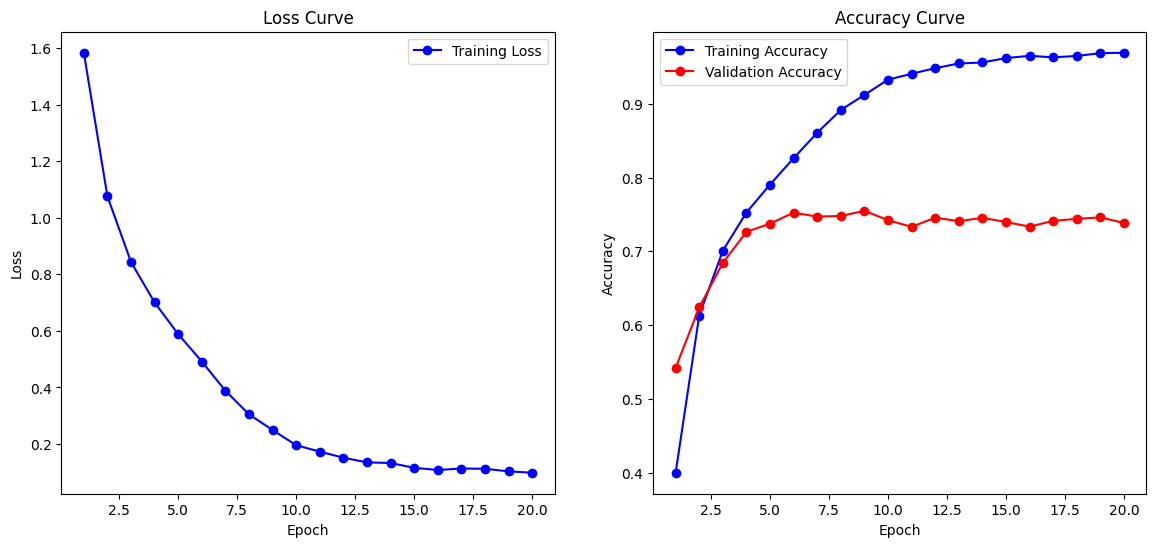


Test Accuracy: 0.7384
Precision: 0.7396
Recall: 0.7384
F1 Score: 0.7374


In [6]:
#Problem 1: Simplified Alexnet model for CIFAR-10 without Dropout

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
bs = 64
lr = 0.001
epochs = 20
n_classes = 10

# Data preprocessing: define transformations
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure image size is 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root="./data", train=True, transform=data_transforms, download=True)
test_data = datasets.CIFAR10(root="./data", train=False, transform=data_transforms, download=True)

# Data loaders
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)

# Define a simplified AlexNet-like model for CIFAR-10
class SimpleAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleAlexNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.classifier(features)
        return outputs

# Initialize the model, loss function, and optimizer
model = SimpleAlexNet(n_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training and validation routine
def run_training(model, train_dl, val_dl, loss_fn, optimizer, num_epochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = epoch_loss / total_train
        train_accuracy = correct_train / total_train
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * imgs.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.4f} | Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, elapsed_time

# Run training
t_loss, t_acc, v_loss, v_acc, total_training_time = run_training(model, train_loader, test_loader, loss_function, optimizer, epochs)
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

# Plotting the loss and accuracy curves
# Plotting the loss and accuracy curves
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(14, 6))

# Plot only the training loss
loss_ax.plot(range(1, epochs + 1), t_loss, 'bo-', label='Training Loss')
# Remove or comment out the validation loss line:
# loss_ax.plot(range(1, epochs + 1), v_loss, 'ro-', label='Validation Loss')
loss_ax.set_xlabel("Epoch")
loss_ax.set_ylabel("Loss")
loss_ax.set_title("Loss Curve")
loss_ax.legend()

# Plot both training and validation accuracy
acc_ax.plot(range(1, epochs + 1), t_acc, 'bo-', label='Training Accuracy')
acc_ax.plot(range(1, epochs + 1), v_acc, 'ro-', label='Validation Accuracy')
acc_ax.set_xlabel("Epoch")
acc_ax.set_ylabel("Accuracy")
acc_ax.set_title("Accuracy Curve")
acc_ax.legend()

plt.show()


# Final evaluation on the test set
model.eval()
final_predictions = []
true_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        final_predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
final_acc = accuracy_score(true_labels, final_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, final_predictions, average='macro')

print(f"\nTest Accuracy: {final_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/20: Train Loss = 1.5479, Train Acc = 0.4206 | Val Loss = 1.1754, Val Acc = 0.5814
Epoch 2/20: Train Loss = 1.0951, Train Acc = 0.6082 | Val Loss = 0.9938, Val Acc = 0.6437
Epoch 3/20: Train Loss = 0.8997, Train Acc = 0.6837 | Val Loss = 0.9160, Val Acc = 0.6869
Epoch 4/20: Train Loss = 0.7703, Train Acc = 0.7321 | Val Loss = 0.8564, Val Acc = 0.7096
Epoch 5/20: Train Loss = 0.6774, Train Acc = 0.7632 | Val Loss = 0.7760, Val Acc = 0.7367
Epoch 6/20: Train Loss = 0.5997, Train Acc = 0.7911 | Val Loss = 0.8010, Val Acc = 0.7338
Epoch 7/20: Train Loss = 0.5419, Train Acc = 0.8116 | Val Loss = 0.8384, Val Acc = 0.7355
Epoch 8/20: Train Loss = 0.4882, Train Acc = 0.8307 | Val Loss = 0.8192, Val Acc = 0.7411
Epoch 9/20: Train Loss = 0.4459, Train Acc = 0.8447 | Val Loss = 0.8234, Val Acc = 0.7472
Epoch 10/20: Train Loss = 0.4131, Train Acc = 0.8577 | Val Loss = 0.8223, Val Acc = 0.7498
Epoch 11/20: Train Loss = 0.3789, Train Acc = 0.8703 | Val Loss = 0.8436, Val Acc = 0.7591
Epoch 12

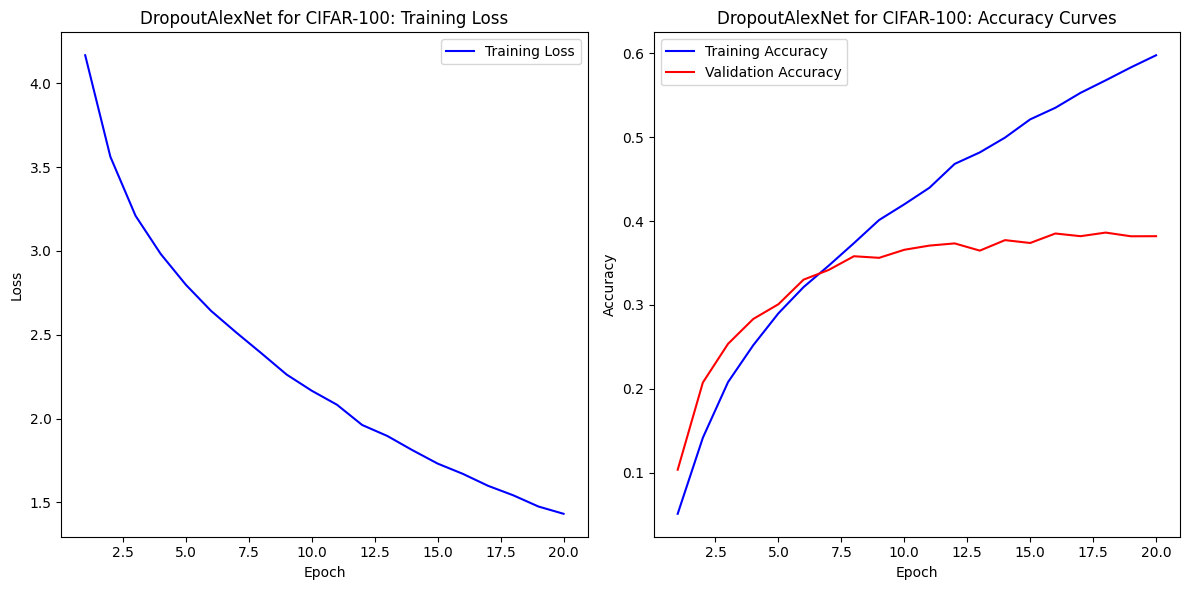


Final Test Accuracy: 0.7557
Precision: 0.7592
Recall: 0.7557
F1 Score: 0.7559


In [13]:
# Problem 1: Simplified Alexnet model CIFAR-10 with Dropout
# Hyperparameters

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20
NUM_CLASSES = 10

# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=data_transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=data_transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define an AlexNet-like architecture with Dropout
class CIFAR10DropoutAlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the model, define loss function and optimizer
model = CIFAR10DropoutAlexNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_and_evaluate(
    net,
    train_dl,
    val_dl,
    loss_fn,
    opt,
    epochs
):
    """
    Trains and evaluates the model, returning loss and accuracy logs.
    """
    train_loss_log, val_loss_log = [], []
    train_acc_log, val_acc_log = [], []

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        # --- Training Phase ---
        net.train()
        total_train_loss = 0.0
        correct_train, total_samples = 0, 0

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_dl)
        train_accuracy = correct_train / total_samples
        train_loss_log.append(avg_train_loss)
        train_acc_log.append(train_accuracy)

        # --- Validation Phase ---
        net.eval()
        total_val_loss = 0.0
        correct_val, total_val_samples = 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for imgs, lbls in val_dl:
                imgs, lbls = imgs.to(device), lbls.to(device)
                val_outputs = net(imgs)

                val_loss = loss_fn(val_outputs, lbls)
                total_val_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                correct_val += (val_predicted == lbls).sum().item()
                total_val_samples += lbls.size(0)

                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(lbls.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dl)
        val_accuracy = correct_val / total_val_samples
        val_loss_log.append(avg_val_loss)
        val_acc_log.append(val_accuracy)

        print(f"Epoch {epoch}/{epochs}: "
              f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.4f} | "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    return train_loss_log, val_loss_log, train_acc_log, val_acc_log, elapsed_time

# Train the network
train_losses, val_losses, train_accuracies, val_accuracies, total_time = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, EPOCHS
)

print(f"\nTraining Completed in {total_time:.2f} seconds")

# --- Plot Results ---
# --- Plotting the Loss and Accuracy ---
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ONLY the training loss
ax_loss.plot(range(1, EPOCHS + 1), train_loss_records, label="Training Loss", color="blue")
# Comment out or remove the validation-loss plot:
# ax_loss.plot(range(1, EPOCHS + 1), val_loss_records, label="Validation Loss", color="red")

ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("DropoutAlexNet for CIFAR-100: Training Loss")
ax_loss.legend()

# Plot training and validation accuracy
ax_acc.plot(range(1, EPOCHS + 1), train_acc_records, label="Training Accuracy", color="blue")
ax_acc.plot(range(1, EPOCHS + 1), val_acc_records, label="Validation Accuracy", color="red")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("DropoutAlexNet for CIFAR-100: Accuracy Curves")
ax_acc.legend()

plt.tight_layout()
plt.show()


# --- Final Evaluation ---
model.eval()
predictions = []
true_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, preds = torch.max(out, 1)
        predictions.extend(preds.cpu().numpy())
        true_vals.extend(labels.cpu().numpy())

final_acc = accuracy_score(true_vals, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_vals, predictions, average="macro")

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/20 | Train Loss: 4.0290, Train Acc: 0.0664 | Val Loss: 3.6293, Val Acc: 0.1294
Epoch 2/20 | Train Loss: 3.3614, Train Acc: 0.1779 | Val Loss: 3.1605, Val Acc: 0.2218
Epoch 3/20 | Train Loss: 2.9126, Train Acc: 0.2664 | Val Loss: 2.8433, Val Acc: 0.2860
Epoch 4/20 | Train Loss: 2.5888, Train Acc: 0.3308 | Val Loss: 2.6747, Val Acc: 0.3284
Epoch 5/20 | Train Loss: 2.3051, Train Acc: 0.3886 | Val Loss: 2.6375, Val Acc: 0.3367
Epoch 6/20 | Train Loss: 2.0100, Train Acc: 0.4547 | Val Loss: 2.6252, Val Acc: 0.3558
Epoch 7/20 | Train Loss: 1.7043, Train Acc: 0.5189 | Val Loss: 2.6900, Val Acc: 0.3600
Epoch 8/20 | Train Loss: 1.3638, Train Acc: 0.6037 | Val Loss: 2.8372, Val Acc: 0.3761
Epoch 9/20 | Train Loss: 1.0340, Train Acc: 0.6897 | Val Loss: 3.2640, Val Acc: 0.3616
Epoch 10/20 | Train Loss: 0.7659, Train Acc: 0.7660 | Val Loss: 3.7495, Val Acc: 0.3586
Epoch 11/20 | Train Loss: 0.5686, Train Acc: 0.8245 | Val Loss: 4.3777, Val Acc: 0.3519
Epoch 12/20 | Train Loss: 0.4395, Train A

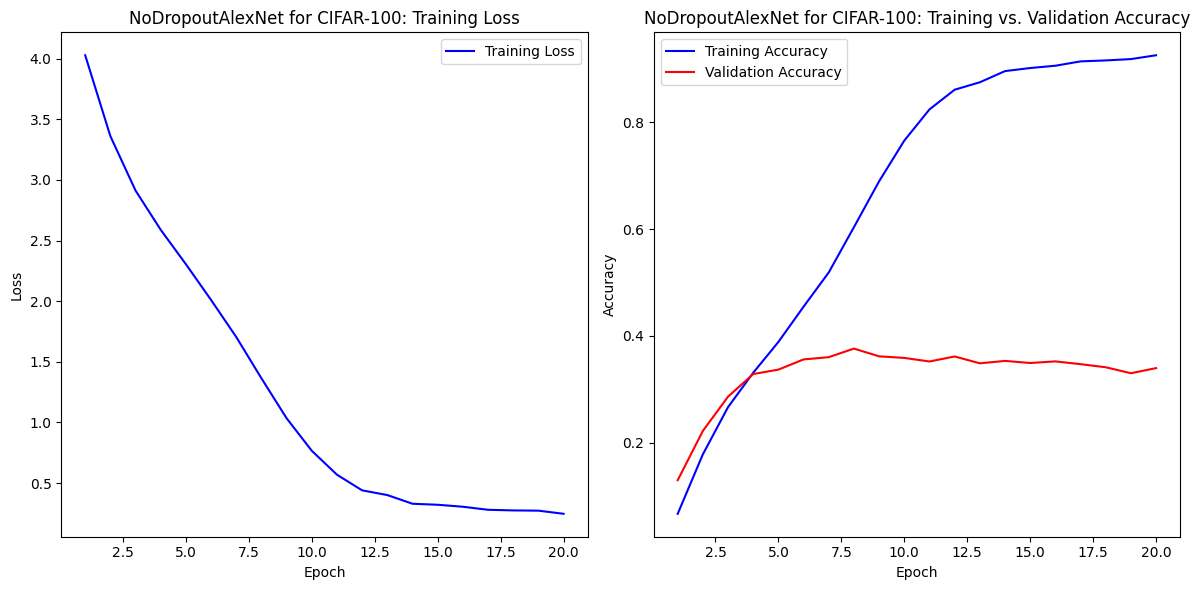


Final Test Accuracy: 0.3395
Precision: 0.3429
Recall: 0.3395
F1 Score: 0.3371


In [16]:
# Problem 1: Simplified Alexnet model CIFAR-100 without Dropout
# Hyperparameters
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 20
NUM_CLASSES = 100

# Define transformations for CIFAR-100 images
cifar100_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-100 dataset
train_data = datasets.CIFAR100(root="./data", train=True, transform=cifar100_transforms, download=True)
test_data = datasets.CIFAR100(root="./data", train=False, transform=cifar100_transforms, download=True)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Define an AlexNet-like model for CIFAR-100 (no dropout)
class NoDropoutAlexNetCIFAR100(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),

            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model, define loss function and optimizer
model = NoDropoutAlexNetCIFAR100(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_experiment(model, train_dl, val_dl, loss_fn, opt, epochs):
    """
    Train and validate the model, returning logs of loss and accuracy.
    """
    train_loss_values, val_loss_values = [], []
    train_acc_values, val_acc_values = [], []

    start_time = time.time()

    for ep in range(1, epochs + 1):
        # --- Training Phase ---
        model.train()
        total_loss = 0.0
        correct_count, total_samples = 0, 0

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_count += (preds == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_dl)
        train_accuracy = correct_count / total_samples
        train_loss_values.append(avg_train_loss)
        train_acc_values.append(train_accuracy)

        # --- Validation Phase ---
        model.eval()
        val_loss_sum = 0.0
        val_correct, val_total = 0, 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for imgs, lbls in val_dl:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                val_loss = loss_fn(outputs, lbls)
                val_loss_sum += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == lbls).sum().item()
                val_total += lbls.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(lbls.cpu().numpy())

        avg_val_loss = val_loss_sum / len(val_dl)
        val_accuracy = val_correct / val_total
        val_loss_values.append(avg_val_loss)
        val_acc_values.append(val_accuracy)

        print(f"Epoch {ep}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    elapsed = time.time() - start_time
    return train_loss_values, val_loss_values, train_acc_values, val_acc_values, elapsed

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, total_time = run_experiment(
    model, train_loader, test_loader, criterion, optimizer, EPOCHS
)

print(f"\nTraining completed in {total_time:.2f} seconds.")

# Plotting the Training Loss and Accuracy
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))

# Plot only the training loss
ax_loss.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", color="blue")
# If you want to see validation loss, uncomment below:
# ax_loss.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", color="red")

ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("NoDropoutAlexNet for CIFAR-100: Training Loss")
ax_loss.legend()

# Plot training and validation accuracy
ax_acc.plot(range(1, EPOCHS + 1), train_accuracies, label="Training Accuracy", color="blue")
ax_acc.plot(range(1, EPOCHS + 1), val_accuracies, label="Validation Accuracy", color="red")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("NoDropoutAlexNet for CIFAR-100: Training vs. Validation Accuracy")
ax_acc.legend()

plt.tight_layout()
plt.show()

# --- Final Evaluation ---
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, pred_labels = torch.max(outputs, 1)
        predictions.extend(pred_labels.cpu().numpy())
        true_labels.extend(lbls.cpu().numpy())

final_acc = accuracy_score(true_labels, predictions)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="macro")

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch 1/20 | Train Loss: 1.5493, Train Acc: 0.4170 | Val Loss: 1.1953, Val Acc: 0.5703
Epoch 2/20 | Train Loss: 1.0780, Train Acc: 0.6156 | Val Loss: 0.9587, Val Acc: 0.6613
Epoch 3/20 | Train Loss: 0.8843, Train Acc: 0.6889 | Val Loss: 0.9297, Val Acc: 0.6800
Epoch 4/20 | Train Loss: 0.7573, Train Acc: 0.7363 | Val Loss: 0.8118, Val Acc: 0.7218
Epoch 5/20 | Train Loss: 0.6690, Train Acc: 0.7671 | Val Loss: 0.8309, Val Acc: 0.7313
Epoch 6/20 | Train Loss: 0.5904, Train Acc: 0.7946 | Val Loss: 0.7274, Val Acc: 0.7534
Epoch 7/20 | Train Loss: 0.5327, Train Acc: 0.8136 | Val Loss: 0.7202, Val Acc: 0.7644
Epoch 8/20 | Train Loss: 0.4847, Train Acc: 0.8321 | Val Loss: 0.7699, Val Acc: 0.7614
Epoch 9/20 | Train Loss: 0.4354, Train Acc: 0.8503 | Val Loss: 0.8083, Val Acc: 0.7578
Epoch 10/20 | Train Loss: 0.4130, Train Acc: 0.8568 | Val Loss: 0.7906, Val Acc: 0.7662
Epoch 11/20 | Train Loss: 0.3830, Train Acc: 0.8687 | Val Loss: 0.7653, Val Acc: 0.7742
Epoch 12/20 | Train Loss: 0.3613, Train A

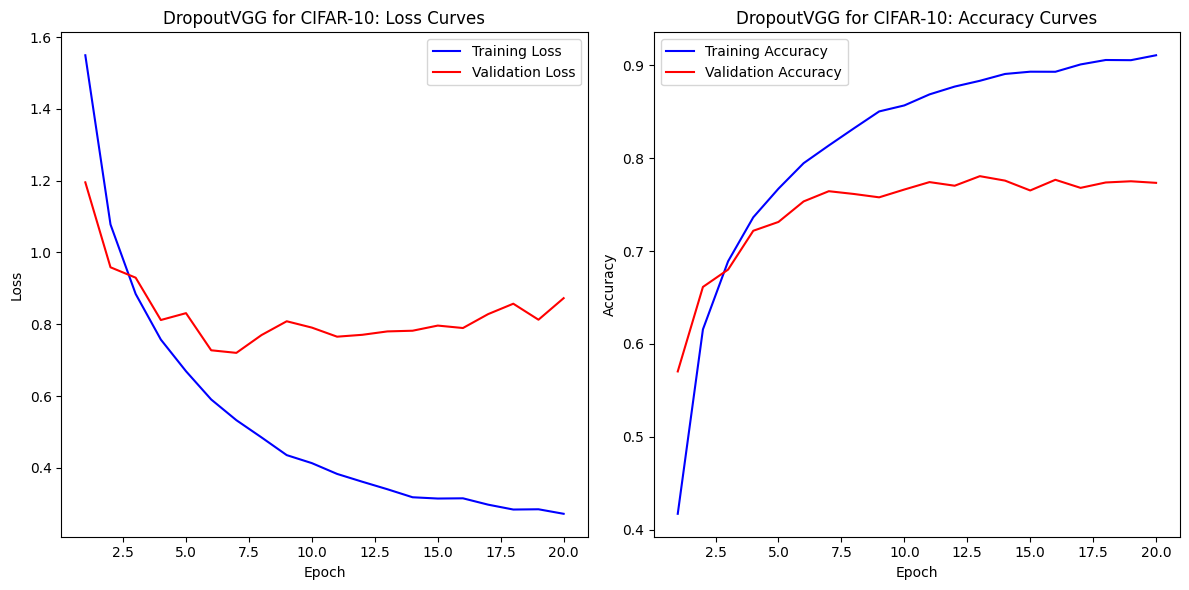


Final Test Accuracy: 0.7734
Precision: 0.7747
Recall: 0.7734
F1 Score: 0.7727


In [19]:
#Problem 2 Simplified VGGnet model CIFAR-10 with Dropout


# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20
NUM_CLASSES = 10

# Transformations for CIFAR-10 images
vgg_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_data = datasets.CIFAR10(root="./data", train=True, transform=vgg_transform, download=True)
test_data = datasets.CIFAR10(root="./data", train=False, transform=vgg_transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Define a simplified VGG-like architecture with dropout for CIFAR-10
class DropoutVGGForCIFAR(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model, define loss and optimizer
vgg_model = DropoutVGGForCIFAR(NUM_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=LEARNING_RATE)

def run_vgg_training(
    model,
    train_dl,
    val_dl,
    criterion,
    opt,
    epochs
):
    """
    Trains and validates the VGG model, returning loss and accuracy logs.
    """
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        # --- Training Phase ---
        model.train()
        total_loss = 0.0
        correct_count = 0
        total_samples = 0

        for imgs, lbls in train_dl:
            imgs, lbls = imgs.to(device), lbls.to(device)

            opt.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_count += (predicted == lbls).sum().item()
            total_samples += lbls.size(0)

        avg_train_loss = total_loss / len(train_dl)
        train_accuracy = correct_count / total_samples
        train_loss_log.append(avg_train_loss)
        train_acc_log.append(train_accuracy)

        # --- Validation Phase ---
        model.eval()
        val_loss_sum = 0.0
        correct_val = 0
        total_val = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for imgs, lbls in val_dl:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)

                val_loss = criterion(outputs, lbls)
                val_loss_sum += val_loss.item()

                _, val_predicted = torch.max(outputs, 1)
                correct_val += (val_predicted == lbls).sum().item()
                total_val += lbls.size(0)

                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(lbls.cpu().numpy())

        avg_val_loss = val_loss_sum / len(val_dl)
        val_accuracy = correct_val / total_val
        val_loss_log.append(avg_val_loss)
        val_acc_log.append(val_accuracy)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    elapsed = time.time() - start_time
    return train_loss_log, val_loss_log, train_acc_log, val_acc_log, elapsed

# Train the VGG model
train_losses, val_losses, train_accs, val_accs, total_time = run_vgg_training(
    vgg_model, train_loader, test_loader, loss_fn, optimizer, EPOCHS
)

print(f"\nTraining completed in {total_time:.2f} seconds.")

# --- Plot the Training & Validation Curves ---
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the training vs. validation loss
ax_loss.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", color="blue")
ax_loss.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", color="red")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("DropoutVGG for CIFAR-10: Loss Curves")
ax_loss.legend()

# Plot the training vs. validation accuracy
ax_acc.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", color="blue")
ax_acc.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", color="red")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("DropoutVGG for CIFAR-10: Accuracy Curves")
ax_acc.legend()

plt.tight_layout()
plt.show()

# --- Final Evaluation ---
vgg_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="macro")

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/20 | Train Loss: 4.1040, Train Acc: 0.0571 | Val Loss: 3.6829, Val Acc: 0.1234
Epoch 2/20 | Train Loss: 3.4016, Train Acc: 0.1679 | Val Loss: 3.1574, Val Acc: 0.2216
Epoch 3/20 | Train Loss: 2.9651, Train Acc: 0.2548 | Val Loss: 2.8965, Val Acc: 0.2778
Epoch 4/20 | Train Loss: 2.6278, Train Acc: 0.3214 | Val Loss: 2.6386, Val Acc: 0.3388
Epoch 5/20 | Train Loss: 2.3286, Train Acc: 0.3835 | Val Loss: 2.5018, Val Acc: 0.3674
Epoch 6/20 | Train Loss: 2.0455, Train Acc: 0.4466 | Val Loss: 2.4910, Val Acc: 0.3765
Epoch 7/20 | Train Loss: 1.7573, Train Acc: 0.5086 | Val Loss: 2.4982, Val Acc: 0.3871
Epoch 8/20 | Train Loss: 1.4635, Train Acc: 0.5798 | Val Loss: 2.6565, Val Acc: 0.3856
Epoch 9/20 | Train Loss: 1.1621, Train Acc: 0.6556 | Val Loss: 2.8435, Val Acc: 0.3916
Epoch 10/20 | Train Loss: 0.8969, Train Acc: 0.7292 | Val Loss: 3.0911, Val Acc: 0.3921
Epoch 11/20 | Train Loss: 0.6822, Train Acc: 0.7884 | Val Loss: 3.5392, Val Acc: 0.3833
Epoch 12/20 | Train Loss: 0.5293, Train A

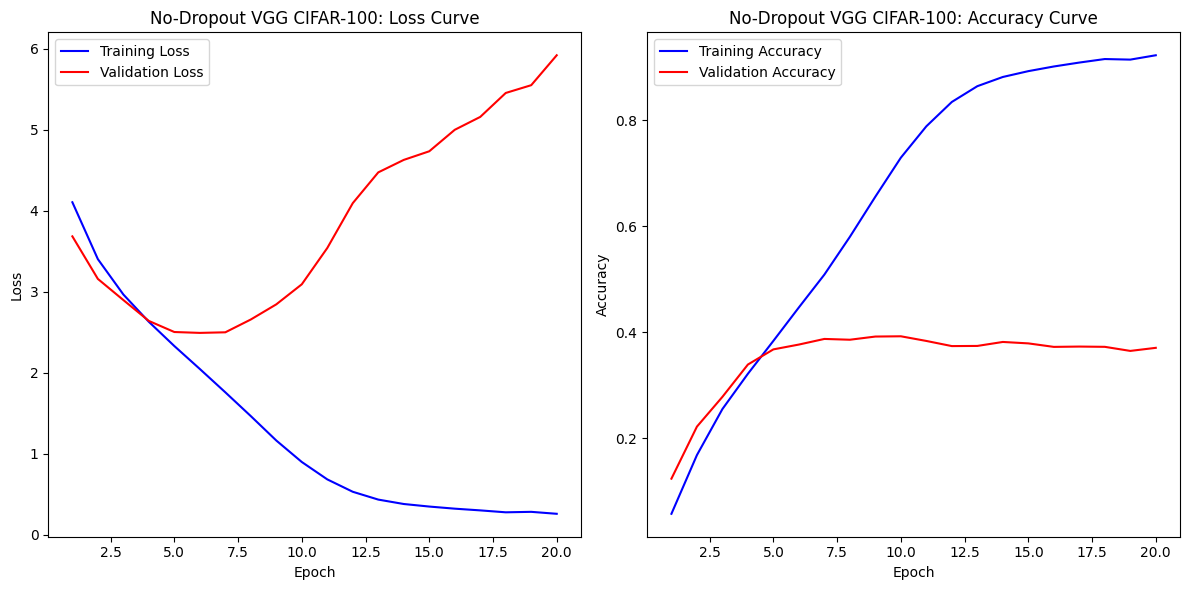


Final Test Accuracy: 0.3703
Precision: 0.3817
Recall: 0.3703
F1 Score: 0.3692


In [20]:
# Problem 2: Simplified VGGnet model CIFAR-100 without Dropout


# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20
NUM_CLASSES = 100

# Data transformations for CIFAR-100
vgg_cifar100_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 datasets
train_data = datasets.CIFAR100(root="./data", train=True, transform=vgg_cifar100_transform, download=True)
test_data  = datasets.CIFAR100(root="./data", train=False, transform=vgg_cifar100_transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

# Define a simplified VGG-like model for CIFAR-100 (no dropout)
class NoDropoutVGG_CIFAR100(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
model = NoDropoutVGG_CIFAR100(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def execute_vgg_training(model, train_dl, val_dl, loss_fn, opt, epochs):
    """
    Train and validate a simplified VGG model on CIFAR-100 without dropout.
    Returns logs of training/validation losses and accuracies.
    """
    train_loss_list = []
    val_loss_list   = []
    train_acc_list  = []
    val_acc_list    = []

    start_time = time.time()

    for ep in range(1, epochs + 1):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train_samples = 0

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_dl)
        train_accuracy = correct_train / total_train_samples
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_accuracy)

        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for imgs, lbls in val_dl:
                imgs, lbls = imgs.to(device), lbls.to(device)
                val_outputs = model(imgs)
                val_loss = loss_fn(val_outputs, lbls)
                total_val_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_preds.extend(val_predicted.cpu().numpy())
                val_targets.extend(lbls.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dl)
        val_accuracy = accuracy_score(val_targets, val_preds)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch {ep}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list, elapsed_time

# Run the training
train_losses, val_losses, train_accs, val_accs, total_time = execute_vgg_training(
    model, train_loader, test_loader, criterion, optimizer, EPOCHS
)

print(f"\nTraining finished in {total_time:.2f} seconds.")

# --- Plotting the Loss and Accuracy ---
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the training vs. validation loss
ax_loss.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", color="blue")
ax_loss.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", color="red")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("No-Dropout VGG CIFAR-100: Loss Curve")
ax_loss.legend()

# Plot the training vs. validation accuracy
ax_acc.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", color="blue")
ax_acc.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", color="red")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("No-Dropout VGG CIFAR-100: Accuracy Curve")
ax_acc.legend()

plt.tight_layout()
plt.show()

# --- Final Evaluation ---
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())
        all_targets.extend(lbls.cpu().numpy())

final_acc = accuracy_score(all_targets, all_predictions)
prec, rec, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average="macro")

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/20: Train Loss: 1.3466, Train Acc: 0.5181 | Val Loss: 1.0751, Val Acc: 0.6240
Epoch 2/20: Train Loss: 0.9526, Train Acc: 0.6662 | Val Loss: 0.8966, Val Acc: 0.6862
Epoch 3/20: Train Loss: 0.7729, Train Acc: 0.7317 | Val Loss: 0.7822, Val Acc: 0.7225
Epoch 4/20: Train Loss: 0.6561, Train Acc: 0.7709 | Val Loss: 0.7707, Val Acc: 0.7371
Epoch 5/20: Train Loss: 0.5591, Train Acc: 0.8052 | Val Loss: 0.7312, Val Acc: 0.7458
Epoch 6/20: Train Loss: 0.4755, Train Acc: 0.8358 | Val Loss: 0.7408, Val Acc: 0.7534
Epoch 7/20: Train Loss: 0.3898, Train Acc: 0.8644 | Val Loss: 0.7878, Val Acc: 0.7521
Epoch 8/20: Train Loss: 0.3152, Train Acc: 0.8903 | Val Loss: 0.7514, Val Acc: 0.7681
Epoch 9/20: Train Loss: 0.2638, Train Acc: 0.9077 | Val Loss: 0.7854, Val Acc: 0.7779
Epoch 10/20: Train Loss: 0.2084, Train Acc: 0.9277 | Val Loss: 0.7954, Val Acc: 0.7780
Epoch 11/20: Train Loss: 0.1669, Train Acc: 0.9419 | Val Loss: 0.8356, Val Acc: 0.7780
Epoch 12/20: Train Loss: 0.1506, Train Acc: 0.9481 |

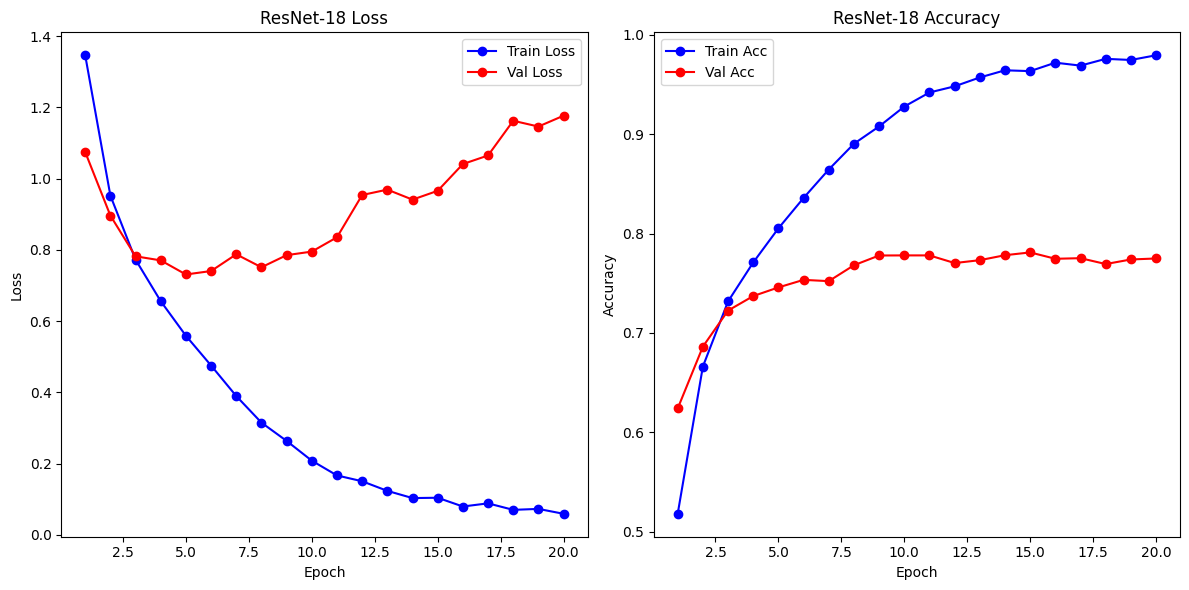


Final Test Accuracy: 0.7749
Precision: 0.7784
Recall: 0.7749
F1 Score: 0.7757


In [21]:
# Problem 3: Simplified VGGnet model CIFAR-10 without Dropout


# Hyperparameters
BS = 64
LR = 0.001
NUM_EPOCHS = 20
NUM_CLASSES = 10

# Data preprocessing for CIFAR-10
data_aug = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Load datasets
train_data = datasets.CIFAR10(root="./data", train=True, transform=data_aug, download=True)
test_data = datasets.CIFAR10(root="./data", train=False, transform=data_aug, download=True)

# Data loaders
train_dl = DataLoader(train_data, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_data, batch_size=BS, shuffle=False)

# Define a Residual Block (Basic Block)
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.downsample = downsample

    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            shortcut = self.downsample(x)
        out += shortcut
        out = self.relu(out)
        return out

# Define a ResNet-18-like model
class MyResNet18(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(MyResNet18, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        ds = None
        if stride != 1 or in_ch != out_ch:
            ds = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        layers = [ResidualBlock(in_ch, out_ch, stride, ds)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate model, criterion, and optimizer
model = MyResNet18(num_classes=NUM_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=LR)

# Custom training routine
def train_resnet(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    start_time = time.time()

    for ep in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_hist.append(epoch_train_loss)
        train_acc_hist.append(epoch_train_acc)

        # Evaluate on validation set
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_predictions = []
        val_truth = []

        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)
                val_predictions.extend(preds.cpu().numpy())
                val_truth.extend(targets.cpu().numpy())

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_hist.append(epoch_val_loss)
        val_acc_hist.append(epoch_val_acc)

        print(f"Epoch {ep+1}/{epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    total_time = time.time() - start_time
    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist, total_time

# Train the model
t_losses, t_accs, v_losses, v_accs, train_time = train_resnet(model, train_dl, test_dl, loss_fn, opt, NUM_EPOCHS)
print(f"\nTotal Training Time: {train_time:.2f} seconds")

# Plot the training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(1, NUM_EPOCHS+1), t_losses, 'b-o', label="Train Loss")
ax1.plot(range(1, NUM_EPOCHS+1), v_losses, 'r-o', label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("ResNet-18 Loss")
ax1.legend()

ax2.plot(range(1, NUM_EPOCHS+1), t_accs, 'b-o', label="Train Acc")
ax2.plot(range(1, NUM_EPOCHS+1), v_accs, 'r-o', label="Val Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("ResNet-18 Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for imgs, targets in test_dl:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

final_acc = accuracy_score(all_targets, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/20 | Train Loss: 1.9310, Train Acc: 0.2852 | Val Loss: 1.5007, Val Acc: 0.4458
Epoch 2/20 | Train Loss: 1.5396, Train Acc: 0.4368 | Val Loss: 1.3317, Val Acc: 0.5028
Epoch 3/20 | Train Loss: 1.3579, Train Acc: 0.5109 | Val Loss: 1.1704, Val Acc: 0.5829
Epoch 4/20 | Train Loss: 1.2569, Train Acc: 0.5581 | Val Loss: 1.1111, Val Acc: 0.6082
Epoch 5/20 | Train Loss: 1.1693, Train Acc: 0.5927 | Val Loss: 0.9742, Val Acc: 0.6614
Epoch 6/20 | Train Loss: 1.1080, Train Acc: 0.6146 | Val Loss: 0.9742, Val Acc: 0.6541
Epoch 7/20 | Train Loss: 1.0554, Train Acc: 0.6397 | Val Loss: 0.9061, Val Acc: 0.6855
Epoch 8/20 | Train Loss: 1.0190, Train Acc: 0.6536 | Val Loss: 0.8304, Val Acc: 0.7146
Epoch 9/20 | Train Loss: 0.9822, Train Acc: 0.6650 | Val Loss: 0.8036, Val Acc: 0.7210
Epoch 10/20 | Train Loss: 0.9468, Train Acc: 0.6782 | Val Loss: 0.8054, Val Acc: 0.7217
Epoch 11/20 | Train Loss: 0.9269, Train Acc: 0.6856 | Val Loss: 0.8152, Val Acc: 0.7216
Epoch 12/20 | Train Loss: 0.9020, Train A

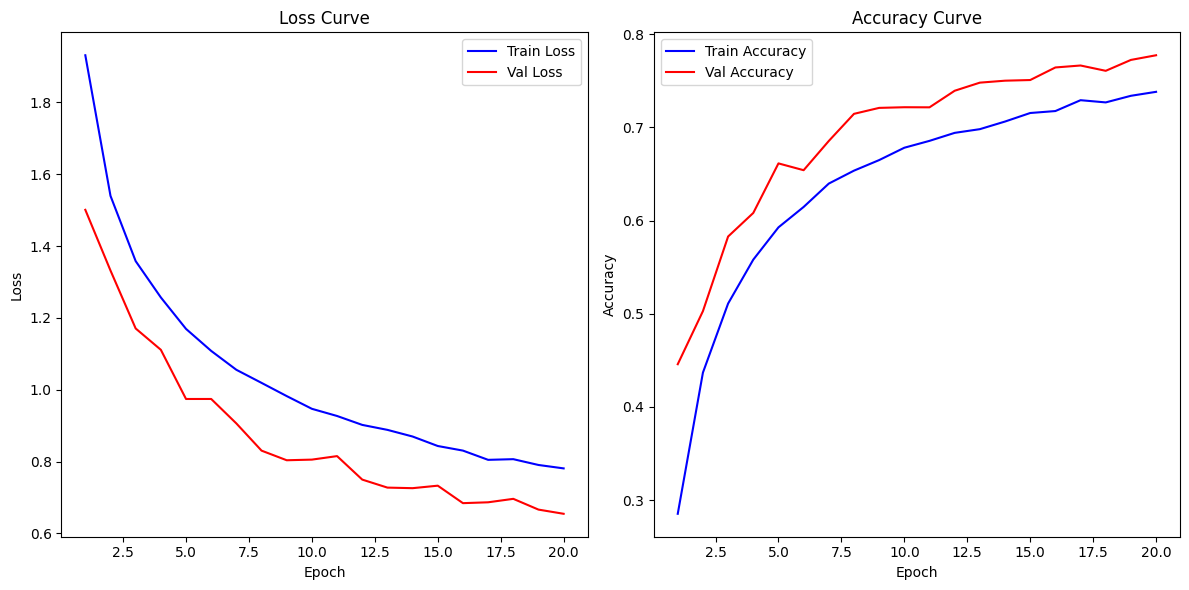


Final Test Accuracy: 0.7775
Precision: 0.7793
Recall: 0.7775
F1 Score: 0.7759


In [22]:
# Problem 3: Simplified Resnet-18 model CIFAR-10 with Dropout

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20
NUM_CLASSES = 10

# Data transformations for CIFAR-10
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
train_set = datasets.CIFAR10(root="./data", train=True, transform=data_transforms, download=True)
test_set  = datasets.CIFAR10(root="./data", train=False, transform=data_transforms, download=True)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define a residual block with dropout
class ResBlockDrop(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.3):
        super(ResBlockDrop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.downsample = downsample

    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)
        out = self.dropout2(out)
        return out

# Define the ResNet-18 model with dropout layers
class ResNet18Drop(nn.Module):
    def __init__(self, in_channels, num_classes, drop_prob=0.3):
        super(ResNet18Drop, self).__init__()
        self.in_channels = 64
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn   = nn.BatchNorm2d(64)
        self.initial_relu = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.init_dropout = nn.Dropout(p=drop_prob)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1, drop_prob=drop_prob)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2, drop_prob=drop_prob)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2, drop_prob=drop_prob)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2, drop_prob=drop_prob)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=drop_prob)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, drop_prob):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResBlockDrop(in_channels, out_channels, stride, downsample, drop_prob))
        for _ in range(1, num_blocks):
            layers.append(ResBlockDrop(out_channels, out_channels, drop_prob=drop_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.initial_relu(out)
        out = self.initial_pool(out)
        out = self.init_dropout(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_dropout(out)
        out = self.fc(out)
        return out

# Instantiate model, loss function, and optimizer
model = ResNet18Drop(in_channels=3, num_classes=NUM_CLASSES, drop_prob=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the training function
def run_training(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # Validation Phase
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / total_val
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    total_elapsed = time.time() - start_time
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, total_elapsed

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, total_time = run_training(model, train_loader, test_loader, criterion, optimizer, num_epochs)
print(f"\nTotal Training Time: {total_time:.2f} seconds")

# Plot the Loss and Accuracy curves
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))
ax_loss.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color="blue")
ax_loss.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color="red")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Loss Curve")
ax_loss.legend()

ax_acc.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", color="blue")
ax_acc.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color="red")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("Accuracy Curve")
ax_acc.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
model.eval()
final_predictions = []
true_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        final_predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(true_labels, final_predictions)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, final_predictions, average="macro")
print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
